In [1]:
import os
from typing import TypedDict, List, Literal
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_ollama import ChatOllama, OllamaEmbeddings
from dotenv import load_dotenv
load_dotenv()

from pinecone import Pinecone
from langchain_pinecone import PineconeVectorStore # <-- Added Pinecone

# Import M3's Persona
from promptss import CORE_SYSTEM_PROMPT, THERAPY_SYSTEM_PROMPT, CRISIS_RESPONSE, SMALLTALK_SYSTEM_PROMPT
from tools import hyperventilation_tool, greeting_tool, TOOL_PROMPTS

# --- CONFIGURATION ---
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY") # <-- New Config (M1 needs this from M2)
INDEX_NAME = "somy-ali-brain"
LLM_MODEL = "llama3.1"
EMBED_MODEL = "nomic-embed-text"

# --- 1. SETUP MODELS ---
print("🔌 Connecting to Brain (Ollama)...")
try:
    llm = ChatOllama(model=LLM_MODEL, temperature=0.7)
except Exception as e:
    print(f"❌ Error connecting to Ollama: {e}")
    llm = None

print("🔌 Connecting to Memory (pinecone)...")
# We connect to the DB created by M2. If it doesn't exist, we skip RAG.
retriever = None
try:
    # Initialize Pinecone Client
    pc = Pinecone(api_key=PINECONE_API_KEY)
    
    # Initialize Embeddings
    embeddings = OllamaEmbeddings(model=EMBED_MODEL)
    
    # Connect to the Index
    vector_store = PineconeVectorStore(
        index_name=INDEX_NAME,
        embedding=embeddings,
        pinecone_api_key=PINECONE_API_KEY
    )
    
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    print("   ✅ Connected to Pinecone Index.")

except Exception as e:
    print(f"   ⚠️ Pinecone Error: {e}")
    print("   Running in 'Amnesia Mode' (No RAG).")

# --- 2. DEFINE STATE ---
# This dictionary holds the data as it moves through the graph nodes
class AgentState(TypedDict):
    messages: List[object] # Chat history
    context: str           # Retrieved book info
    is_safe: bool          # Safety flag
    filter_category: str  # From Router
    active_tool: str

# --- 3. DEFINE NODES (The Workers) ---

def safety_check(state: AgentState):
    """Worker 1: The Guardrail (M4 Logic)"""
    # Get the last message from the user
    # We check if messages list is not empty
    if not state["messages"]:
        return {"is_safe": True}
    
    last_msg = state["messages"][-1].content.lower()
    danger_words = [
    # Core suicide terms
    "suicide",
    "suicidal",
    "kill myself",
    "end my life",
    "take my own life",
    "want to die",
    "wish I were dead",
    "death is the only solution",
    "self-harm",
    "self harm",
    "hurt myself",
    "harm myself",
    "cut myself",
    "cutting",
    "bleed to death",
    "cut my veins",
    "smash my head",
    "punish myself",
    "overdose",
    "poison myself",
    "jump off",
    "jump in front of a train",
    "drown myself",
    "suffocate myself",
    "end it all",
    "end the pain",
    "end my suffering",
    "stop existing",
    "disappear forever",
    "vanish from this world",
    "escape life",
    "free from life",
    "life is meaningless",
    "life is not worth living",
    "no reason to live",
    "no future for me",
    "tired of being alive",
    "done with life",
    "giving up on life",
    "I am a burden",
    "everyone would be better without me",
    "no one would miss me",
    "tonight",
    "right now",
    "anymore"
]
    
    # Check if safe
    is_unsafe = any(word in last_msg for word in danger_words)
    
    if is_unsafe:
        print("🚨 GUARDRAIL HIT: Unsafe content detected.")
        
    return {"is_safe": not is_unsafe}

def router_node(state: AgentState):
    """Worker 1.5: The AI Router (Reuses LLM)"""
    if not llm: return {"filter_category": "general"}
    
    user_text = state["messages"][-1].content
    
        # --- 1. CHECK FOR SPECIFIC TOOLS FIRST --- new added in Week 5(changes)
    
    # Hyperventilation Trigger
    if any(phrase in user_text for phrase in ["can't breathe", "panic attack", "chest tight", "hyperventilating"]):
        print("🚦 Router decided: TOOL -> HYPERVENTILATION")
        return {"filter_category": "hyperventilation", "active_tool": "hyperventilation"}

    # Greeting Trigger (strict: short greetings only)
    greetings = ["hi", "hello", "hey", "good morning", "good evening"]
    if user_text.strip() in greetings or (len(user_text.split()) < 3 and any(g in user_text for g in greetings)):
        print("🚦 Router decided: TOOL -> GREETING")
        return {"filter_category": "general", "active_tool": "greeting"}
    
    # Fast Classification Prompt
    router_prompt = f"""
    Classify the following text into ONE category: 
    [anxiety, depression, trauma, anger, grief, sleep, addiction, child, general].
    
    Text: "{user_text}"
    
    Return ONLY the category word. No markdown, no punctuation.
    """
    
    try:
        print("🚦 Router Thinking...")
        # We reuse 'llm' here. No new memory used.
        response = llm.invoke([HumanMessage(content=router_prompt)])
        category = response.content.strip().lower()
        
        # Cleanup output (sometimes LLM says "Category: anxiety")
        valid_cats = ["anxiety", "depression", "trauma", "anger", "grief", "sleep", "addiction", "child"]
        found_cat = "general"
        for v in valid_cats:
            if v in category:
                found_cat = v
                break
                
        print(f"   ✅ AI Decided: {found_cat.upper()}")
        return {"filter_category": found_cat}
        
    except Exception as e:
        print(f"❌ Router Error: {e}")
        return {"filter_category": "general"}

def retrieve_knowledge(state: AgentState):
    """Worker 2: The Smart Librarian (Updated for Week 3)"""
    if not retriever:
        return {"context": "No medical manuals available."}
    
    print("🔍 Searching Knowledge Base...")
    user_text = state["messages"][-1].content.lower()
    
    # --- METADATA ROUTING LOGIC ---
    # We check the user's text for keywords to decide which "Book" to open.
    # This matches the tags M2 created in 'ingest_with_tags.py'.
    
    target_category = state.get("filter_category", "general")
    filter_dict = None # Default: Search everything
    
    if target_category == "child":
        print("   🏷️ Filter: Audience='child'")
        filter_dict = {"audience": "child"}
    elif target_category != "general":
        print(f"   🏷️ Filter: Category='{target_category}' OR 'general'")
        filter_dict = {
            "$or": [
                {"category": target_category},
                {"category": "general"} 
            ]
        }
    else:
        print("   🏷️ No specific filter (General).")
        
        
    # --- EXECUTE SEARCH ---
    try:
        # We pass the 'filter' to the retriever
        if filter_dict:
            docs = retriever.invoke(user_text, filter=filter_dict)
        else:
            docs = retriever.invoke(user_text) # Search everything if no keyword found
            
        # Combine results
        if not docs:
            return {"context": "No specific manual found for this topic."}
            
        context_text = "\n\n".join([d.page_content for d in docs])
        return {"context": context_text}
        
    except Exception as e:
        print(f"   ⚠️ Retrieval Failed: {e}")
        return {"context": "Error retrieving context."}
    

def generate_response(state: AgentState):
    """Worker 3: The Psychologist (M3 Logic)"""
    
    # If safety check failed, return crisis message immediately
    if not state["is_safe"]:
        return {"messages": [AIMessage(content=CRISIS_RESPONSE)]}
    
    if not llm:
        return {"messages": [AIMessage(content="System Error: AI Model not connected.")]}


    current_category = state.get("filter_category", "general")
    
    # Define "Therapy Categories" that require the clinical persona
    clinical_categories = ["anxiety", "depression", "trauma", "anger", "grief", "sleep", "addiction", "child"]
    
     # Also check if we actually found helpful context (RAG success)
    has_context = state.get("context") and "No specific manual found" not in state.get("context")
    
    #new line added in Week 5
    user_input = state["messages"][-1].content.lower()

        # --- DYNAMIC PROMPT CONSTRUCTION ---
    
    # 1. Base Prompt Selection
    if current_category in clinical_categories or has_context:
        print(f"   🧠 Mode: THERAPY (Category: {current_category})")
        base_prompt = THERAPY_SYSTEM_PROMPT.format(context=state.get("context", "No manuals."))
        
        # 2. Tool-Specific Guidance (from TOOL_PROMPTS in tools.py)
        # If the category matches a key in TOOL_PROMPTS, append that specific advice
        if current_category in TOOL_PROMPTS:
            tool_advice = TOOL_PROMPTS[current_category]
            base_prompt += f"\n\nSPECIFIC GUIDANCE FOR {current_category.upper()}:\n{tool_advice}"
            
        final_system_prompt = CORE_SYSTEM_PROMPT + "\n" + base_prompt

    else:
        # Check for 'Serious General' vs 'True Smalltalk'
        serious_triggers = ["feel", "life", "hard", "problem", "confused", "lost", "struggle", "help", "mind", "tired"]
        is_serious = any(trigger in user_input for trigger in serious_triggers) or len(user_input.split()) > 10
        
        if is_serious:
            print("   🧠 Mode: THERAPY (General Serious)")
            final_system_prompt = CORE_SYSTEM_PROMPT + "\n" + THERAPY_SYSTEM_PROMPT.format(context=state.get("context", "No manuals."))
        else:
            print(f"   💬 Mode: SMALLTALK (Category: {current_category})")
            final_system_prompt = CORE_SYSTEM_PROMPT + "\n" + SMALLTALK_SYSTEM_PROMPT
        
    print("🤖 Generating Response...")
    
    # Inject the retrieved context into the System Prompt
    # If context is empty, it just uses general knowledge
    # filled_prompt = SOMY_SYSTEM_PROMPT.format(context=state.get("context", "No manuals."))
    
    # Build the conversation history for the LLM:
    # We create a new list for the LLM call to ensure structure is correct
    conversation_for_llm = [SystemMessage(content=final_system_prompt)] + state["messages"]
    
    try:
        response = llm.invoke(conversation_for_llm)
        return {"messages": [response]}
    except Exception as e:
        print(f"❌ Error invoking LLM: {e}")
        return {"messages": [AIMessage(content="I am having trouble finding the right words. Can you say that again?")]}

# --- 4. BUILD THE GRAPH ---
workflow = StateGraph(AgentState)

# Add the workers to the graph
workflow.add_node("safety", safety_check)
workflow.add_node("router", router_node)
workflow.add_node("retrieve", retrieve_knowledge)
workflow.add_node("generate", generate_response)
workflow.add_node("hyperventilation_tool", hyperventilation_tool) # NEW NODE
workflow.add_node("greeting_tool", greeting_tool)                 # NEW NODE

# Define the Flow: Start -> Safety
workflow.set_entry_point("safety")

# Define Conditional Flow (The "Traffic Cop")
def route_safety(state: AgentState) -> Literal["router", "generate"]:
    if state["is_safe"]:
        return "router" # If safe, go get knowledge -- gp through router
    else:
        return "generate" # If unsafe, skip to generation (which will output crisis msg)

workflow.add_conditional_edges("safety", route_safety)

def route_tools(state: AgentState) -> Literal["hyperventilation_tool", "greeting_tool", "retrieve"]:
    tool = state.get("active_tool")
    if tool == "hyperventilation":
        return "hyperventilation_tool"
    elif tool == "greeting":
        return "greeting_tool"
    else:
        return "retrieve" # Default path
    
workflow.add_conditional_edges("router", route_tools)

# Tool Nodes end the graph (they return a final response)
workflow.add_edge("hyperventilation_tool", END)
workflow.add_edge("greeting_tool", END)

# Normal Flow
workflow.add_edge("retrieve", "generate")
workflow.add_edge("generate", END)

# Compile the machine
app_graph = workflow.compile()


c:\Users\Shaziya khan\Desktop\Somyali_backend_project_V2\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔌 Connecting to Brain (Ollama)...
🔌 Connecting to Memory (pinecone)...
   ✅ Connected to Pinecone Index.


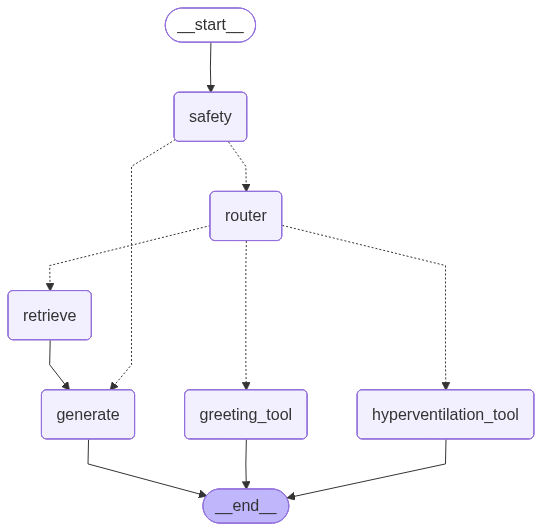

In [2]:
app_graph
